In [1]:
import subprocess
import os
import ete3
import random
import numpy as np
from Bio import SeqIO
import pandas as pd
import multiprocessing
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import random
from scipy.stats import spearmanr, linregress

#
# initial definitions
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

%cd /work/site_rate/sequence_simulation
%matplotlib inline
num_replicates      = 100
sequence_length     = 5000
num_rate_categories = 12

/work/site_rate/sequence_simulation


In [2]:
random.seed(12345)
np.random.seed(12345)

indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

[MODEL] modelHug [submodel]  LG                         //   LG
                 [rates]     0 0.8025 12                //   pinv=0, alpha=1.3, discrete gamma categories=20
                 [statefreq]
                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
                    0.0055   0.0293   0.0535   0.0956   // A R N D C
                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
                    0.0253   0.0280   0.0415   0.0519   // L K M F P
                    0.0516   0.0065   0.0217   0.0898   // S T W Y V

[MODEL] modelHemimastigophora [submodel]  LG            //   LG
                 [rates]     0 0.8025 20                //   pinv=0, alpha=0.8648, discrete gamma categories=20
                 [statefreq]
                    0.0801  0.0593  0.0369  0.0535   // list of 20 numbers
                    0.0173  0.0340  0.0623  0.0677   // A R N D C
                    0.0226  0.0648  0.1001  0.0630   // Q E G H I
                    0.0269  0.0429  0.0389  0.0549   // L K M F P
                    0.0515  0.0102  0.0325  0.0804   // S T W Y V

[TREE] T2  {t2}
[TREE] T3  {t3}

[PARTITIONS] partition2 [T2 modelHemimastigophora {length}]   // tree T2, model model1, root length 1000
[PARTITIONS] partition3 [T3 modelHug {length}]   // tree T3, model model1, root length 1000

[EVOLVE]    //partition2  {num_replicates}   {t2_name}
            partition3  {num_replicates}   {t3_name}
'''

taxa_names = [f'taxa_{count:04}' for count in range(1,1001)]
base_tree  = ete3.Tree()
base_tree.populate(size=1000, names_library=taxa_names, random_branches=True)

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


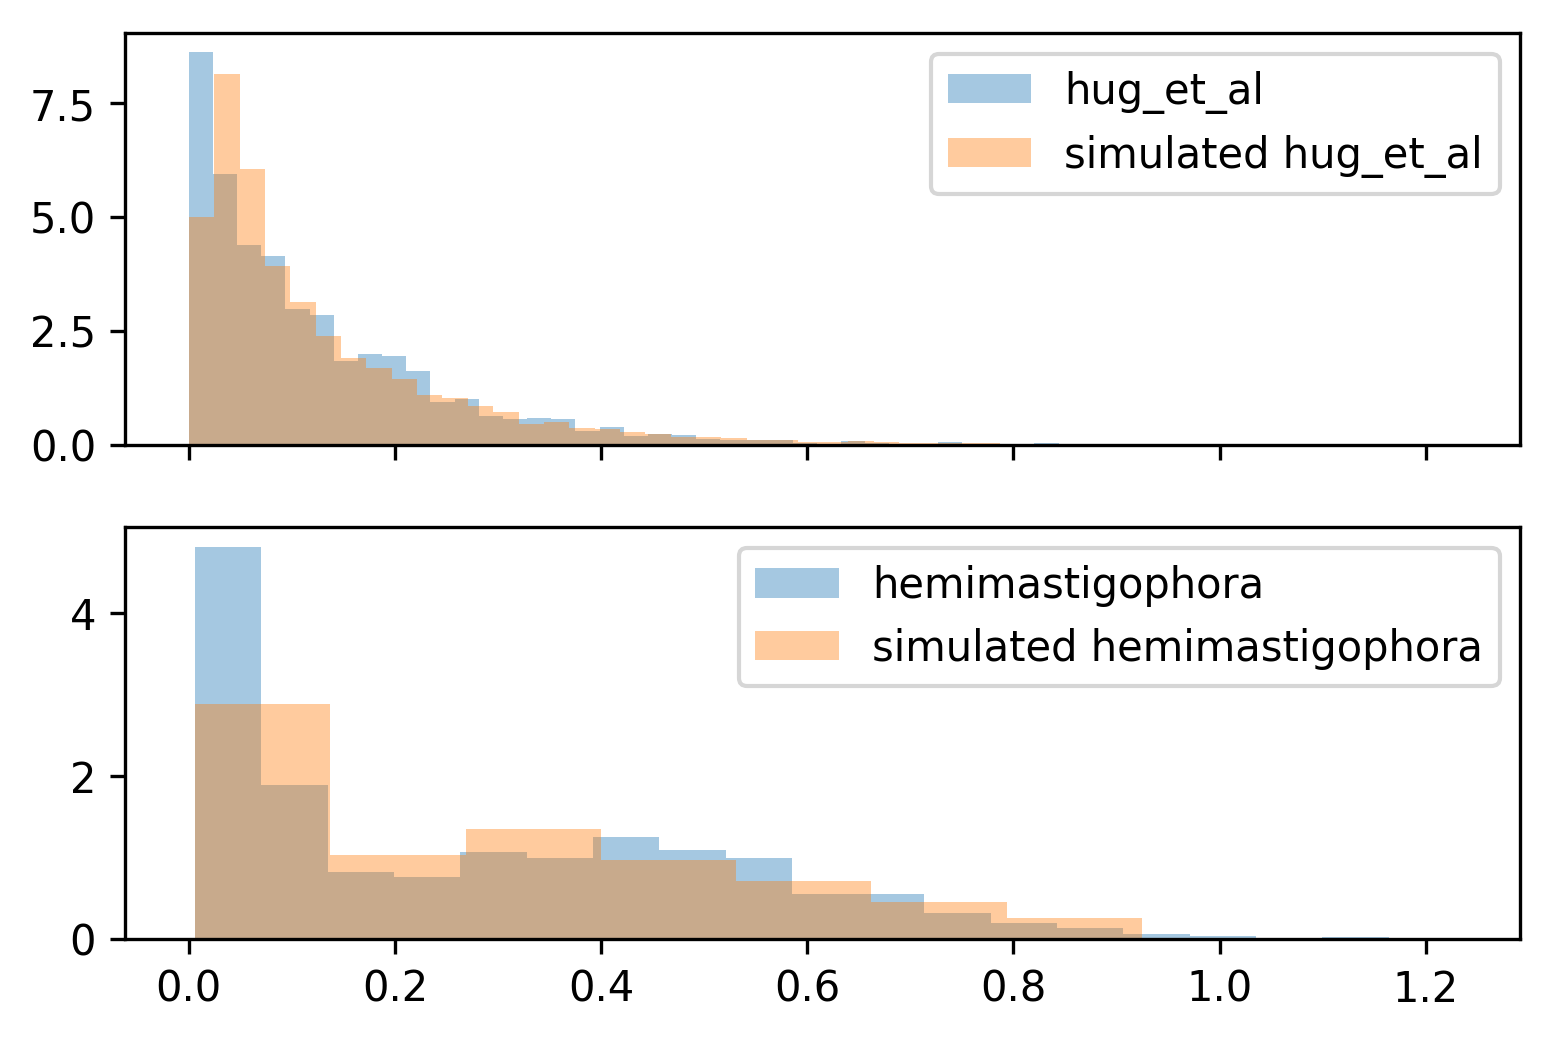

In [3]:
trees = {}
fig, axs = plt.subplots(nrows=2, dpi=300, sharex=True)
for tree_name, ax in zip('hug_et_al hemimastigophora'.split(), axs):
    tmp_tree                = ete3.Tree('../%s/species.tre' % tree_name)
    internal_branch_lengths = [node.dist for node in tmp_tree.traverse()
                               if not node.is_root() and not node.is_leaf()]
    leaf_branch_lengths     = [node.dist for node in tmp_tree.get_leaves()]

    #
    # https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy
    fit_alpha, fit_loc, fit_beta        = stats.gamma.fit(internal_branch_lengths)
    internal_branch_length_distribution = stats.gamma(fit_alpha, loc=fit_loc, scale=fit_beta)
    
    fit_alpha, fit_loc, fit_beta        = stats.gamma.fit(leaf_branch_lengths)
    terminal_branch_length_distribution = stats.gamma(fit_alpha, loc=fit_loc, scale=fit_beta)

    trees[tree_name] = base_tree.copy()
    for node in trees[tree_name].traverse():
        if node.is_root():
            continue
        elif node.is_leaf():
            tmp_branch_length = -1
            while tmp_branch_length < 0:
                tmp_branch_length = terminal_branch_length_distribution.rvs(1)[0]
            node.dist = tmp_branch_length
        else:
            tmp_branch_length = -1
            while tmp_branch_length < 0:
                tmp_branch_length = internal_branch_length_distribution.rvs(1)[0]
            node.dist = tmp_branch_length
            #node.dist = internal_branch_length_distribution.rvs(1)[0]
    
    sns.distplot([node.dist for node in trees[tree_name].traverse() if not node.is_root()],
                 ax=ax, kde=False, norm_hist=True, label=tree_name)
    sns.distplot([node.dist for node in tmp_tree.traverse() if not node.is_root()],
                 ax=ax, kde=False, norm_hist=True, label='simulated '+tree_name)
    ax.legend()

In [4]:
out = open('control.txt', 'w')
out.write(indelible_conf.format(t2=trees['hemimastigophora'].write(format=5, dist_formatter='%.20f'),
                                t2_name='hemimastigophora_br_length',
                                t3=trees['hug_et_al'].write(format=5, dist_formatter='%.20f'),
                                t3_name='hug_br_length',
                                num_replicates=num_replicates, length=sequence_length))
out.close()

subprocess.call(['/work/site_rate/indelible/INDELibleV1.03/bin/indelible_1.03_OSX_intel'])

0

In [ ]:
## commented...
##fasta = open('hemimastigophora_br_length.fas').read().strip()
##trees['hemimastigophora'].write(outfile='hemimastigophora/reference.tre', format=5, dist_formatter='%.20f')
##for count, block in enumerate(fasta.split('\n     \n')):
##    out = open('hemimastigophora/%i.fas' % (count+1), 'w')
##    out.write(block)
##    out.close()

In [5]:
fasta = open('hug_br_length.fas').read().strip()
trees['hug_et_al'].write(outfile='hug/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('hug/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

In [6]:
#
# classify sites into rate-categories
def write_rates(argument):
    partition_name, replicate_number = argument
    subprocess.call(['iqtree', '-s', '%s/%i.fas' % (partition_name, replicate_number), '-m', 'LG+G12', '-redo',
                     '-safe', '-wsr', '-nt', '1', '-n', '0', '-pre', '%s/%i' % (partition_name, replicate_number),
                     '-te', '%s/reference.tre' % partition_name, '-quiet'])

num_threads = 5
pool = multiprocessing.Pool(processes=num_threads)
pool.map(write_rates, product('hemimastigophora hug'.split()[1:], range(1, num_replicates+1)))

Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/thiberio

KeyboardInterrupt: 

In [8]:
#
# parse rates classification
#
for partition_name in 'hemimastigophora hug'.split()[1:]:
    print(partition_name)

    with cd(partition_name):
#        if not os.path.isdir('categories'):
#            os.mkdir('categories')
#        else:
#            os.system('rm -r categories/*')

#        for replicate in range(1, num_replicates+1):
        for replicate in [1]:
            if not os.path.isfile('%i.rate' % replicate):
                print(replicate)
                continue
            alignment = list(SeqIO.parse('%i.fas' % replicate, 'fasta'))

            rates = pd.read_table('%i.rate' % replicate, comment='#')
            for category in rates.Cat.unique():
                site_df        = rates[rates.Cat == category]
                category_aln   = {sequence.name:'' for sequence in alignment}
                for sequence in alignment:
                    category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

                out = open('categories/%i.%i.aln' % (replicate, category), 'w')
                for header, sequence in category_aln.items():
                    full_sequence = ''
                    while len(full_sequence) <= 5000:
                        full_sequence += sequence
                    out.write('>%s\n%s\n' % (header, full_sequence[:5000]))
                out.close()

hug


In [ ]:
def run_bootstrap(argument):
    replicate_number, category = argument
    subprocess.call(['iqtree', '-s', '%i.%i.aln' % (replicate_number, category), '-m', 'LG+G1', '-redo',
                     '-safe', '-nt', '1', '-pre', '%i.%i' % (replicate_number, category),
                     '-bb', '1000', '-keep-ident', '-quiet', '-wbt'])

for partition_name in 'hemimastigophora hug'.split()[1:]:
    with cd('%s/categories' % partition_name):
        pool = multiprocessing.Pool(processes=15)
        pool.map(run_bootstrap, product(range(1, num_replicates+1), range(1, 13)))

In [70]:
%cd /work/site_rate/sequence_simulation/hug
bipartitions   = []
branch_lengths = []
for node in ete3.Tree('reference.tre').traverse():
    if node.is_leaf() or node.is_root():
        continue
    bipartitions.append(set(node.get_leaf_names()))
    branch_lengths.append(node.dist)

/work/site_rate/sequence_simulation/hug


In [60]:
%cd /work/site_rate/sequence_simulation/hug
results = []
for n in range(1, 101):
    if not all(os.path.isfile('categories/%i.%i.ufboot' % (n, category)) for category in range(1, 13)):
        print('%i\n\tmissing one of the categories' % n)
        continue
    
    
    compatible_branch_lengths = []
    for category in range(1, 13):
        suptree = ete3.Tree('categories/%i.%i.ufboot.suptree' % (n, category))
        compatible_branch_lengths.append(
            [node.dist for node in suptree.traverse() if not node.is_leaf() and
                                                         not node.is_root() and
                                                             node.support >= 80]
        )
    results.append(compatible_branch_lengths)

/work/site_rate/sequence_simulation/hug
1
	missing one of the categories
2
3
4
5
6
7
8
9
	missing one of the categories
10
11
12
13
14
15
16
17
18
19
	missing one of the categories
20
	missing one of the categories
21
	missing one of the categories
22
	missing one of the categories
23
	missing one of the categories
24
	missing one of the categories
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
	missing one of the categories
93
	missing one of the categories
94
	missing one of the categories
95
	missing one of the categories
96
	missing one of the categories
97
	missing one of the categories
98
	missing one of the categories
99
	missing one of the categories
100


In [13]:
import matplotlib.colors

cmap = plt.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=12)
colors = ['#%02x%02x%02x' % cmap(norm(index), bytes=8)[:3]
          for index in range(0,13)]

In [71]:
fig, axs = plt.subplots(dpi=200, figsize=(10,300), nrows=84)
counter = 0
spearman_correlations = []
spearman_pvals        = []
for n, ax in zip(results, axs):
    counter += 1
    if not os.path.isfile('%i.rate' % counter):
        while not os.path.isfile('%i.rate' % counter):
            counter += 1

    rates     = pd.read_table('%i.rate' % counter, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)
    
#    spearman = spearmanr([np.median(x) for x in n], rates.C_Rate.tolist())
#    spearman_correlations.append(spearman.correlation)
#    spearman_pvals.append(spearman.pvalue)
    
    boxplot = ax.boxplot(n, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=False,
                         boxprops={'linewidth':1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':1,
                                      'color':'k'})

    ax.plot(ax.get_xlim(), [np.median(branch_lengths), np.median(branch_lengths)], '--',
            c='k', alpha=0.5, label='median branch length')

    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
    ax.set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
#    ax.set_ylim(0, 0.3)
#    ax.legend()
    ax.set_title('Replicate %i' % counter)
fig.tight_layout()

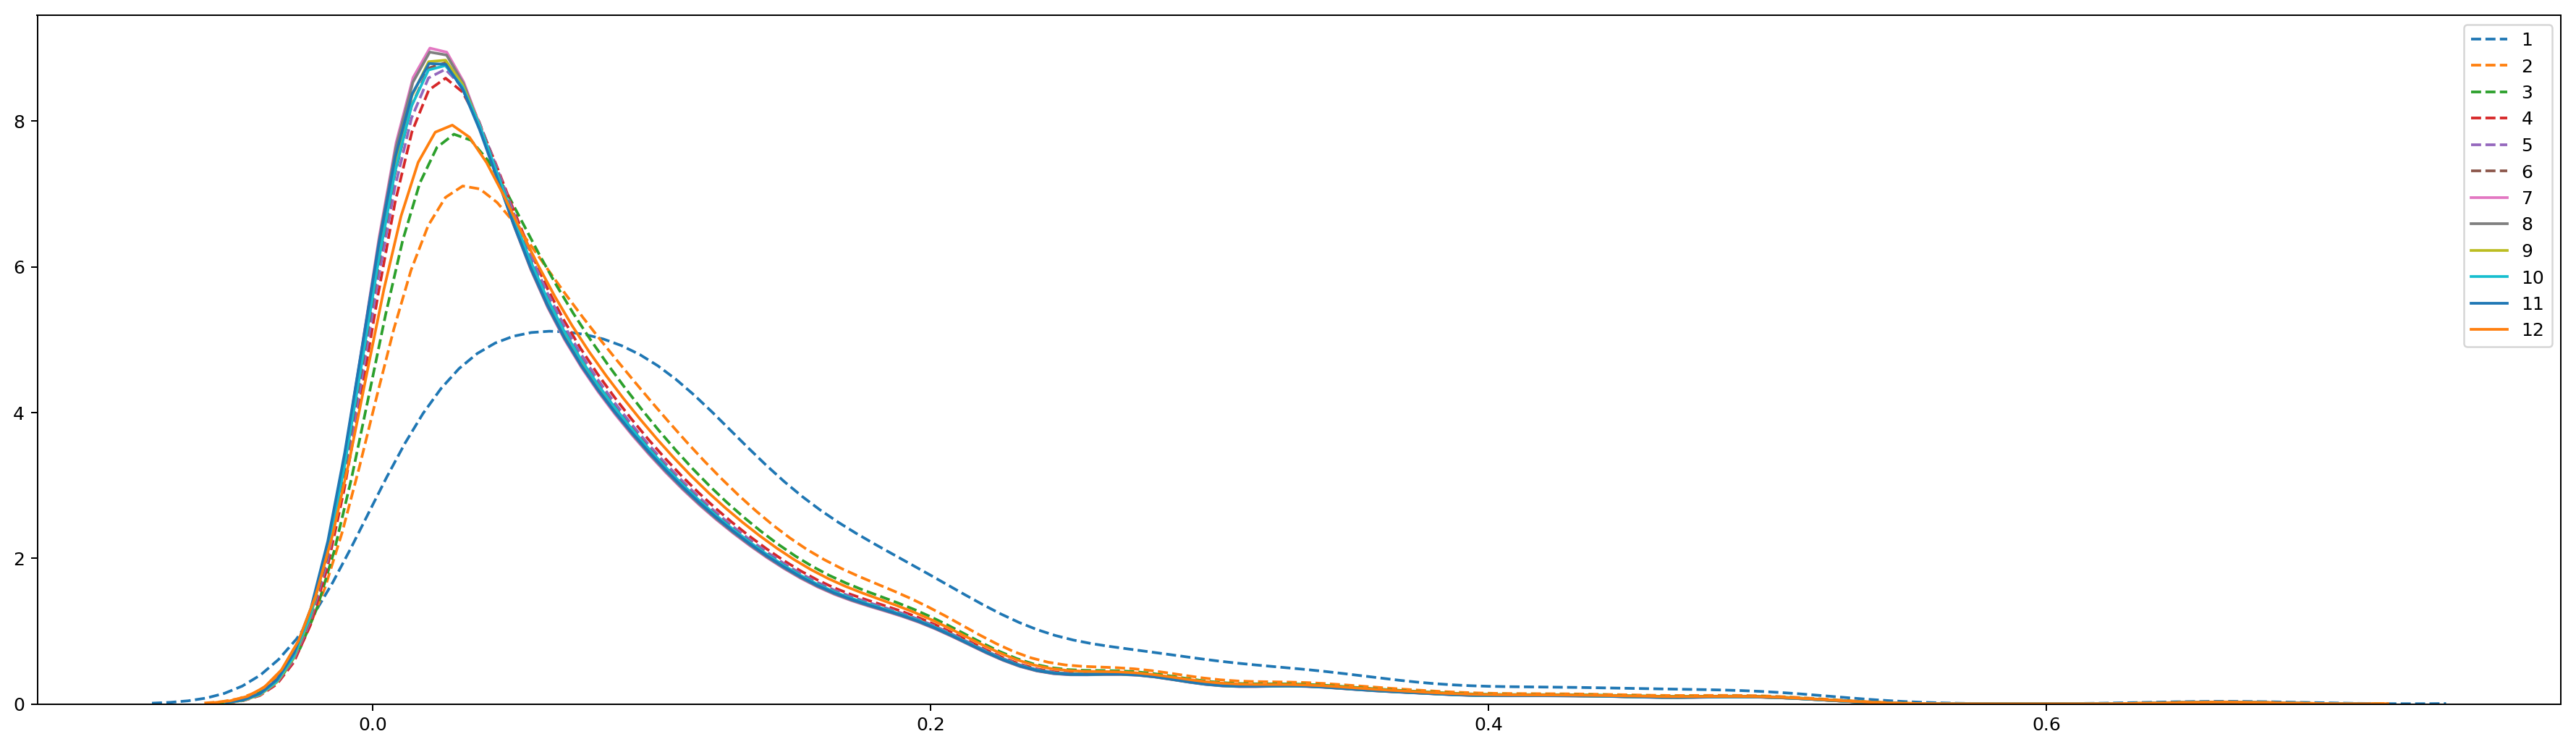

In [64]:
fig, ax = plt.subplots(dpi=180, figsize=(25,7))
for i,j in enumerate(n, 1):
    if i > 6:
        linestyle = '-'
    else:
        linestyle = '--'
    sns.kdeplot(j, shade=False, label=i, ax=ax, linestyle=linestyle)

In [19]:
from statsmodels.sandbox.stats.multicomp import multipletests
spearman_correlations = np.asarray(spearman_correlations)
true_correlations = multipletests(spearman_pvals, method='fdr_bh', alpha=0.05)[0]
spearman_correlations[true_correlations].std()

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [10]:
%cd /work/site_rate/sequence_simulation/hug/categories/rf
random.seed(12345)
slopes = []
for replicate in range(1, 101):
    if not all(os.path.isfile('%i.%i.rfdist' % (replicate, category)) 
               for category in range(1, 13)):
        print('%i\n\tmissing one of the categories' % replicate)
        continue

    distances = []
    for category in range(1,13):
        iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    x = rates.C_Rate.tolist()[-4:]
    y = [np.median(n) for n in distances[-4:]]
    slopes.append(linregress(x,y).slope)

/work/site_rate/sequence_simulation/hug/categories/rf


In [11]:
np.mean(slopes), np.std(slopes)

(26.23800577564768, 9.100358539942986)

In [1]:
%cd /work/site_rate/sequence_simulation/hug/categories/rf
random.seed(12345)
fig, axs = plt.subplots(dpi=200, figsize=(10,300), nrows=100)
ax_counter = -1
median_rfs   = []
median_rates = []
for replicate in range(1, 101):
    if not all(os.path.isfile('%i.%i.rfdist' % (replicate, category)) 
               for category in range(1, 13)):
        print('%i\n\tmissing one of the categories' % replicate)
        continue

    ax_counter += 1
    distances = []
    for category in range(1,13):
        iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    boxplot = axs[ax_counter].boxplot(distances, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=False,
                         boxprops={'linewidth':0.1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':0.1,
                                      'color':'k'})
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    axs[ax_counter].set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
    axs[ax_counter].set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
    axs[ax_counter].set_title('Replicate %i' % replicate)

fig.tight_layout()

/work/site_rate/sequence_simulation/hug/categories/rf


NameError: name 'random' is not defined

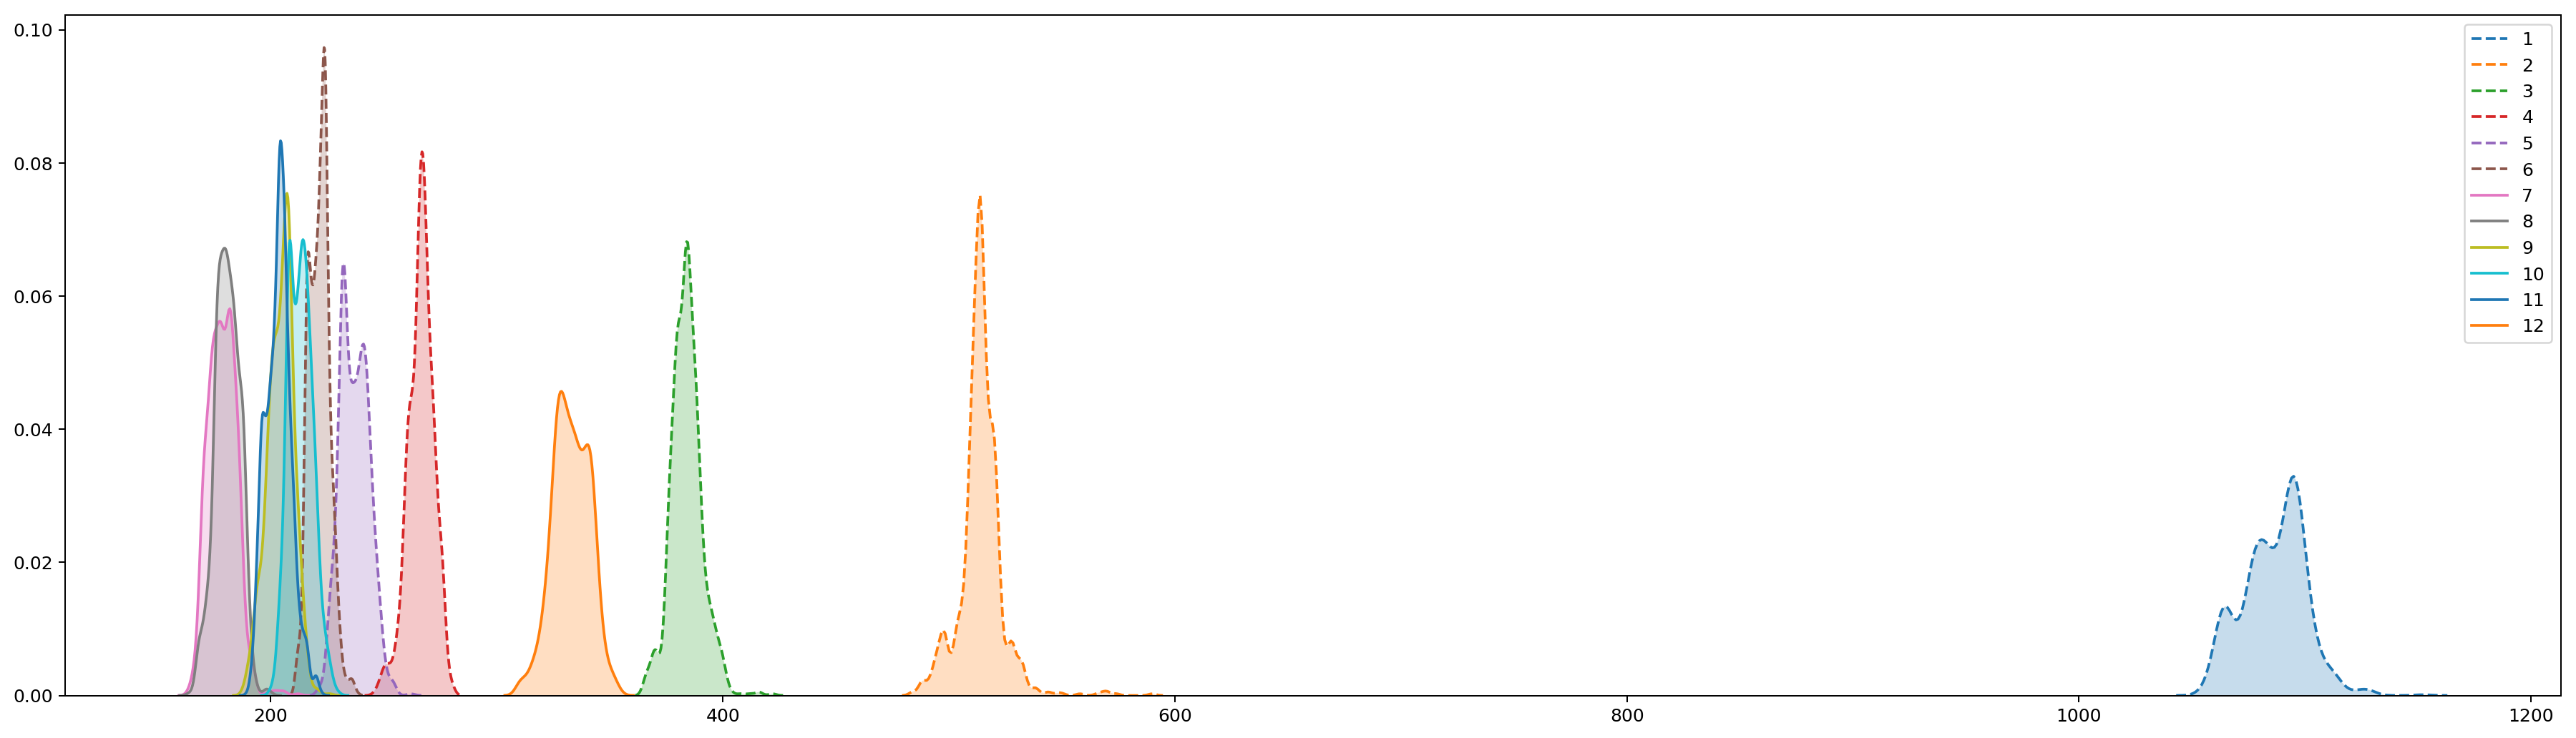

In [51]:
fig, ax = plt.subplots(dpi=180, figsize=(25,7))
for i,j in enumerate(distances, 1):
    if i > 6:
        linestyle = '-'
    else:
        linestyle = '--'
    sns.kdeplot(j, shade=True, label=i, ax=ax, linestyle=linestyle)

/work/site_rate/sequence_simulation/hug/jtt_categories


NameError: name 'colors' is not defined

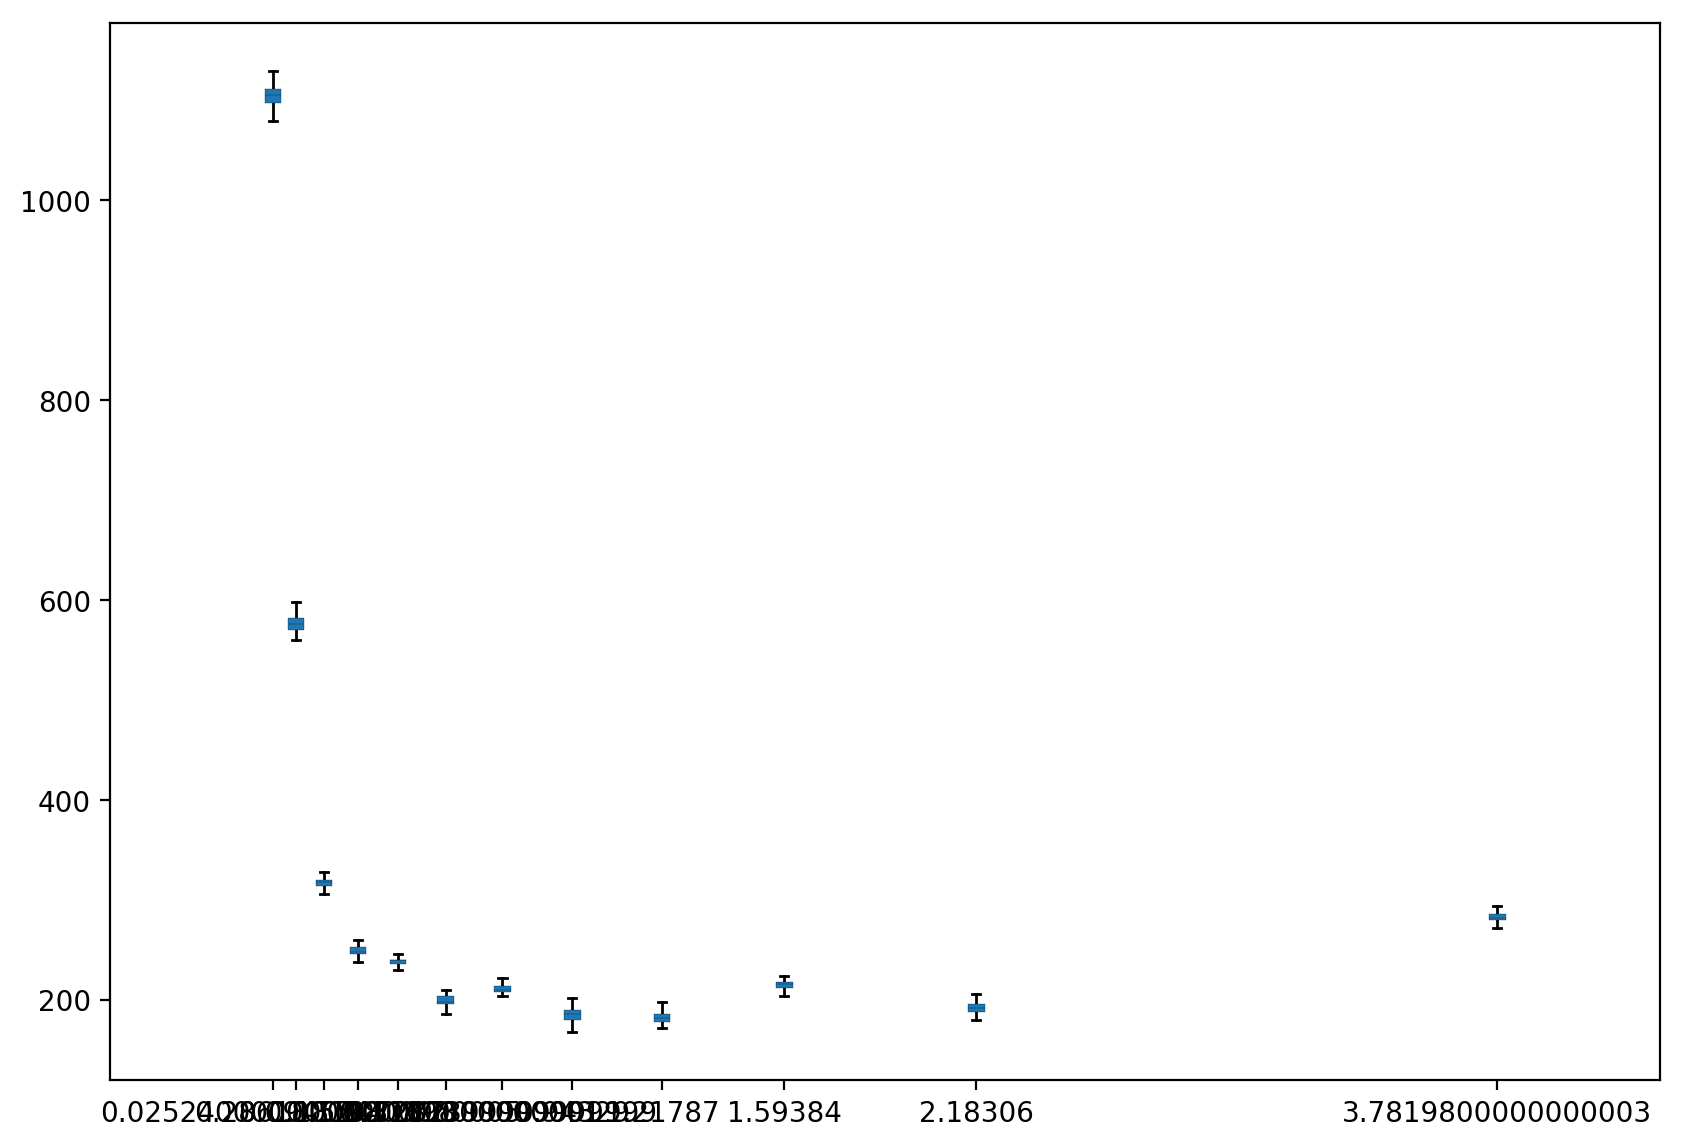

In [9]:
%cd /work/site_rate/sequence_simulation/hug/jtt_categories/
random.seed(12345)
fig, ax = plt.subplots(dpi=200, figsize=(10,7))
ax_counter = -1
median_rfs   = []
median_rates = []
for replicate in range(1, 101)[:1]:
    ax_counter += 1
    distances = []
    for category in range(1,13):
        iqtree_result = open('jtt_rf_%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    boxplot = ax.boxplot(distances, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=False,
                         boxprops={'linewidth':0.1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':0.1,
                                      'color':'k'})
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
    ax.set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
    ax.set_title('Replicate %i' % replicate)

fig.tight_layout()